# Detection Data Generator 
- 해당 Jupyter Script 에서는 데이터를 Detection 을 하기 위한  MNIST 데이터를 추출합니다. 
- 추출할 데이터의 형태는 아래와 같습니다. 
  - Image: 
      - 이미지 크기 : 128 x 128 x  3 형태로 생성됩니다. 
      - normalize 여부 : min-max normalize 적용
      - noise 여부 : 추가 되어 있음
      - 
  
  - Labels: 

In [1]:
import os
from label_generator import label_generator
from model import simple_detection_netowrk
from dataset import DetectionDataset
from default_boxes import generate_tiling_default_boxes
from utils import xywh2xyxy
from tqdm import tqdm
from time import time
import numpy as np
import tensorflow as tf
import pickle
from delta import calculate_gt
from utils import images_with_rectangles, plot_images

In [2]:
# Load dataset
trainset = DetectionDataset(data_type='train')
gt_img, gt_info = trainset[0]
gt_coords = gt_info.iloc[:, 1:5].values
gt_labels = gt_info.iloc[:, -1].values
n_classes = 10 + 1

In [3]:
# Generate detection SSD model
n_boxes = 5
inputs, (cls3_5, loc3_7), (cls4_5, loc4_7), (cls5_5, loc5_7) = simple_detection_netowrk(gt_img.shape,
                                                                                        n_boxes,
                                                                                        n_classes=11)
multi_head_cls = [cls3_5, cls4_5, cls5_5]
multi_head_loc = [loc3_7, loc4_7, loc5_7]
n_head = len(multi_head_loc)

# classification, localization head 을 합침
# cls: (N, h, w, n_classes * 5) -> (N, h * w, n_classes*5),
# loc: (N, h, w, 4*5) -> (N, h * w, 4*5)
pred_merged_cls = tf.concat(
    [tf.reshape(head_cls, (-1, np.prod(head_cls.get_shape()[1:3]), n_boxes, n_classes)) for head_cls in multi_head_cls],
    axis=1)
pred_merged_loc = tf.concat(
    [tf.reshape(head_loc, (-1, np.prod(head_loc.get_shape()[1:3]), n_boxes, 4)) for head_loc in multi_head_loc],
    axis=1)
pred = tf.concat([pred_merged_loc, pred_merged_cls], axis=-1)
pred = tf.reshape(pred, shape=(-1, np.prod(pred.get_shape()[1:3]), n_classes + 4))


In [4]:
# 각 header 는 하나의 scale 을 사용함, ratio 는 공유
scales = [10, 25, 40]
ratios = [(1, 1), (1.5, 0.5), (1.2, 0.8), (0.8, 1.2), (1.4, 1.4)]
assert len(multi_head_cls) == len(multi_head_loc) == len(scales)

# stem layer , block 2 마지막 layer 까지 layer argument 정의(※ 모든 multi head 는 root 을 공유함)
stem_n_layer = 5
stem_paddings = ['SAME'] * stem_n_layer
stem_kernel_sizes = [3] * stem_n_layer
stem_strides = [1, 1, 1, 1, 2]

# block 당 추가되는
block_padding = ['SAME', 'SAME']
block_kernel_sizes = [3, 3]
block_stride = [1, 2]

# multi head 시 추가되는 layer argument(모든 layer 는 같은 layer argument 을 사용함)
head_kernel_size = [3]
head_stride = [1]
head_padding = ['SAME']

# Generate default boxes
default_boxes_bucket = []

# 모든 multi head 에서 default boxes 을 구합니다.
for head_ind in tqdm(range(n_head)):
    # get feature map size
    trgt_fmap_size = multi_head_cls[head_ind].get_shape()[1:3]
    trgt_scale = scales[head_ind]
    trgt_paddings = stem_paddings + block_padding * (head_ind + 1)
    trgt_kernel_sizes = stem_kernel_sizes + block_kernel_sizes * (head_ind + 1)
    trgt_strides = stem_strides + block_stride * (head_ind + 1)

    default_boxes = generate_tiling_default_boxes(fmap_size=trgt_fmap_size,
                                                  paddings=trgt_paddings,
                                                  strides=trgt_strides,
                                                  kernel_sizes=trgt_kernel_sizes,
                                                  scales=[trgt_scale],
                                                  ratios=ratios)
    default_boxes = default_boxes.reshape(-1, 4)
    default_boxes_bucket.append(default_boxes)


100%|██████████| 3/3 [00:00<00:00, 792.72it/s]


In [5]:
f = open('../datasets/default_boxes_bucket.pkl', 'wb')
pickle.dump(default_boxes_bucket, f)

In [ ]:
trues = []
true_imgs = []
s_time = time()
for gt_img, gt_info in tqdm(trainset):

    # shape (N_img, 4=(cx cy w h))
    gt_coords = gt_info.iloc[:, 1:5].values
    gt_labels = gt_info.iloc[:, -1].values

    # ground truth coordinates(xcx cy w h), shape = (N_obj, 4)
    gt_coords = gt_coords.reshape(-1, 4)

    # 각 header 별 delta, cls 을 구합니다.
    each_header_loc = []
    each_header_cls = []
    for default_boxes in default_boxes_bucket:
        true_delta, true_cls = label_generator(default_boxes, gt_coords)
        each_header_loc.append(true_delta)
        each_header_cls.append(true_cls)

    # (N_a, 11*n_anchor), (N_b, 11*n_anchor), (N_c, 11*n_anchor) -> (N_a + N_b + N_c, 11*n_anchor)
    true_head_loc = np.concatenate(each_header_loc, axis=0)

    # (N_a, 1*n_anchor), (N_b, 1*n_anchor), (N_c, 1*n_anchor) -> (N_a + N_b + N_c, 1*n_anchor)
    true_head_cls = np.concatenate(each_header_cls, axis=0)

    # (N_a + N_b + N_c, 4*n_anchor), (N_a + N_b + N_c) -> (N_a + N_b + N_c, 11*n_anchor + 1*n_anchor)
    true = np.concatenate([true_head_loc, true_head_cls[:, None]], axis=-1)

    # 각 header 별 delta, cls 을 각 global bucket 에 추가합니다.
    trues.append(true)
    true_imgs.append(gt_img)

os.makedirs('../datasets', exist_ok=True)
np.save('../datasets/true_labels.npy', np.array(trues))
np.save('../datasets/true_images.npy', np.array(true_imgs))

consume_time = time() - s_time
print('consume_time : {}'.format(consume_time))
print('transaction units : {}'.format(11000 / consume_time))
print('Finish generate detection dataset!')


  9%|▉         | 1021/11000 [00:10<01:35, 104.70it/s]

### Checking Generated Dataset
 - positive 한 영역에서 박스가 쳐지는 지 확인합니다

In [19]:
len(trues)

11000

In [20]:
# divide localization, classification
true_cls = np.array(trues)[..., 4:]
true_delta = np.array(trues)[..., :4]

# merged default_boxes_bucket to default boxes 
merged_default_boxes = np.concatenate(default_boxes_bucket, axis=0)


In [21]:
true_loc_bucket = [] 
for delta in true_delta:
    true_loc = calculate_gt(default_boxes = merged_default_boxes, delta_hat=delta)
    true_loc_bucket.append(true_loc)

In [24]:
index_per_image = []  
loc_per_img = [] 
for ind, cls in enumerate(true_cls):
    pos_index = np.where(np.squeeze(cls) != -1)
    index_per_image.append(pos_index)
    true_loc_bucket[ind][pos_index]
    loc_per_img.append(xywh2xyxy(true_loc_bucket[ind][pos_index]))


In [25]:
rected_imgs = images_with_rectangles(imgs=np.array(true_imgs)*255, bboxes_bucket=loc_per_img)

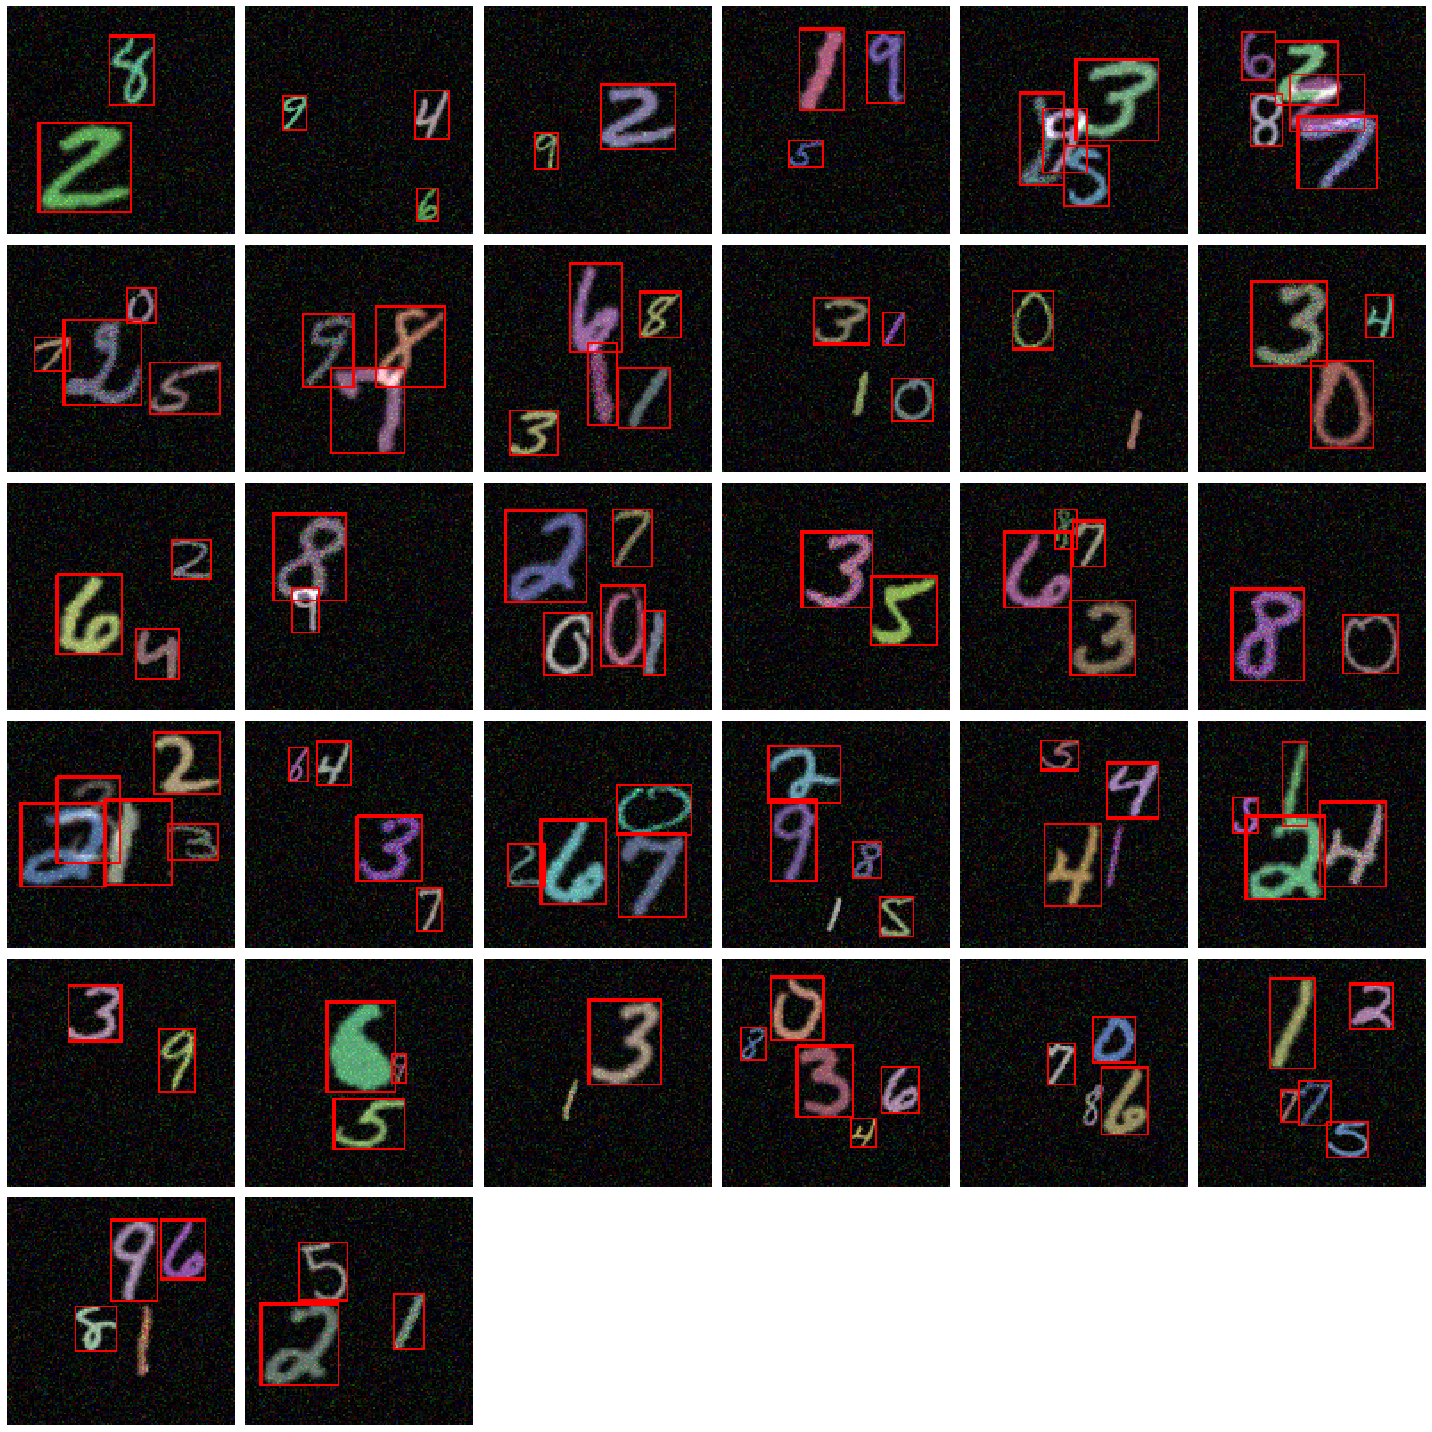

In [26]:
plot_images(rected_imgs[32:64])